In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
import numpy as np
import torch
import json
from equistore import Labels, TensorBlock, TensorMap
from torch_builder import TensorBuilder
import ase.io
from itertools import product
from torch_cg import ClebschGordanReal
from torch_hamiltonians import fix_pyscf_l1, dense_to_blocks, blocks_to_dense, couple_blocks, decouple_blocks, hamiltonian_features
import matplotlib.pyplot as plt
from rascal.representations import SphericalExpansion
import copy
from ase.units import Hartree

In [3]:
import sys
# sys.path.insert(0,'/Users//new-hamiltonian/equistore-examples')
from utils.librascal import  RascalSphericalExpansion, RascalPairExpansion
from utils.acdc_mini import acdc_standardize_keys, cg_increment, cg_combine

In [87]:
frames = ase.io.read("../data/hamiltonian/water-hamiltonian/water_coords_1000.xyz",":100")
for f in frames:
    f.cell = [100,100,100]
    f.positions += 50

In [88]:
#jorbs = json.load(open('data/water-hamiltonian/water_orbs.json', "r"))
jorbs = json.loads(json.load(open('../data/hamiltonian/water-hamiltonian/water_orbs.json', "r")))
orbs = {}
zdic = {"O" : 8, "H":1}
for k in jorbs:
    orbs[zdic[k]] = jorbs[k]

In [89]:
hams = np.load("../data/hamiltonian/water-hamiltonian/water_saph_orthogonal.npy", allow_pickle=True)[:len(frames)]
# NO NEED TO CORRECT L1 ORDER FOR SAPH ORTHOGONALIZED MATRICES...
#for i, f in enumerate(frames):
#    hams[i] = fix_pyscf_l1(hams[i], f, orbs)

In [90]:
cg = ClebschGordanReal(5)

In [91]:
#loss functions
def mse_full(fock, pred_blocks, frame, orbs):
    predicted = blocks_to_dense(decouple_blocks(pred_blocks), frame, orbs)
    mse_loss = torch.empty(len(frame))
    for i in range(len(frame)):
        mse_loss[i] = (torch.linalg.norm(fock[i]-predicted[i]))**2/len(fock[i])
        #print("from mse", i, fock[i], mse_loss[i])
    return torch.mean(mse_loss)

def mse_eigvals(fock, pred_blocks, frame, orbs):
    predicted = blocks_to_dense(decouple_blocks(pred_blocks), frame, orbs)
    evanorm = torch.empty(len(frame))
    for i in range(len(frame)):
        evanorm[i] = torch.mean((torch.linalg.eigvalsh(fock[i]) - torch.linalg.eigvalsh(predicted[i]))**2)/len(fock[i])
    return torch.mean(evanorm)

In [92]:
def normalize_feats(feat, all_blocks=True): 
    all_norm = 0
    for block_idx, block in feat: 
        block_norm = np.linalg.norm(block.values)
#         print(block_idx, block_norm)
        all_norm += block_norm**2
    normalized_blocks=[]
    for block_idx, block in feat: 
        newblock = TensorBlock(
                        values=block.values/np.sqrt(all_norm ),
                        samples=block.samples,
                        components=block.components,
                        properties= block.properties)
                    
        normalized_blocks.append(newblock) 
        
    norm_feat = TensorMap(feat.keys, normalized_blocks)
    return norm_feat

## Manipulate Hamiltonian into blocks

In [93]:
blocks = dense_to_blocks(hams, frames, orbs)
fock_bc = couple_blocks(blocks, cg)

## Feature computation

In [94]:
rascal_hypers = {
    "interaction_cutoff": 2.5,
    "cutoff_smooth_width": 0.5,
    "max_radial": 6,
    "max_angular": 4,
    "gaussian_sigma_type": "Constant",
    "compute_gradients":  False,
}

spex = RascalSphericalExpansion(rascal_hypers)
rhoi = spex.compute(frames)

In [95]:
pairs = RascalPairExpansion(rascal_hypers)
gij = pairs.compute(frames)

In [96]:
rho1i = acdc_standardize_keys(rhoi)
rho1i.keys_to_properties(['species_neighbor'])
gij =  acdc_standardize_keys(gij)

In [97]:
rho2i = cg_increment(rho1i, rho1i, lcut=2, other_keys_match=["species_center"], clebsch_gordan=cg)

In [98]:
# rho3i = cg_increment(rho2i, rho1i, lcut=2, other_keys_match=["species_center"], clebsch_gordan=cg)

In [99]:
rho1ij = cg_increment(rho1i, gij, lcut=2, other_keys_match=["species_center"], clebsch_gordan=cg)

In [100]:
rho2ij = cg_increment(rho2i, gij, lcut=2, other_keys_match=["species_center"], clebsch_gordan=cg)

In [101]:
ham_feats = hamiltonian_features(rho2i, rho1ij)

In [102]:
norm_ham_feats = normalize_feats(ham_feats)

# Pytorch Model

In [103]:
class LinearModel(torch.nn.Module):
    def __init__(self, coupled_blocks, features, weights=None, intercepts=None):
        super().__init__()
        self.coupled_blocks = coupled_blocks
        self.features = features
        self.weights = {}
        if weights==None:
            for idx_fock, block_fock in self.coupled_blocks:
                block_type, ai, ni, li, aj, nj, lj, L = idx_fock
                parity= (-1)**(li+lj+L)
                size = self.features.block(block_type=block_type, spherical_harmonics_l=L,inversion_sigma=parity, 
                                       species_center=ai, species_neighbor=aj).values.shape[2]
                self.weights[idx_fock] = torch.nn.Parameter(torch.zeros(size, dtype=torch.float64))
            
        else: 
            self.weights = weights
            
        if intercepts is not None:
            self.intercepts = intercepts 
            
        else:
            self.intercepts = None
         
    def forward(self, features):
        k = []
        pred_blocks = []
        for (idx, wts) in self.weights.items():
            #print(wts)
            block_type, ai, ni, li, aj, nj, lj, L = idx
            k.append(list(idx))
            parity= (-1)**(li+lj+L)
            X = features.block(block_type=block_type, spherical_harmonics_l=L,inversion_sigma=parity, 
                                   species_center=ai, species_neighbor=aj)
            X_new = torch.from_numpy(X.values.reshape(-1, X.values.shape[2]))
            #print(idx, wts.shape, X.values.shape, X_new.shape)
            if self.intercepts is not None:
                Y = X_new @ wts + self.intercepts[idx]
            else:
                Y = X_new @ wts
            
            newblock = TensorBlock(
                        values=Y.reshape((-1, 2 * L + 1, 1)),
                        samples=X.samples,
                        components=[Labels(
                            ["mu"], np.asarray(range(-L, L + 1), dtype=np.int32).reshape(-1, 1)
                        )],
                        properties= Labels(["values"], np.asarray([[0]], dtype=np.int32))
                    )
            pred_blocks.append(newblock) 
        
        keys = Labels(('block_type', 'a_i', 'n_i', 'l_i', 'a_j', 'n_j', 'l_j', 'L'), np.asarray(k, dtype=np.int32))
        pred_fock = TensorMap(keys, pred_blocks)
        return(pred_fock)
        ### add direct eigenvalue prediction here as well
    
    def parameters(self):
        for idx, wts in self.weights.items():
            yield wts        

# For single frame

In [71]:
i_frame = frames[0]
i_ham = hams[0] 

i_feats = ham_feats.slice(Labels(names=["structure"], values=np.asarray(range(1), dtype=np.int32).reshape(-1,1)) )
i_focks = fock_bc.slice(Labels(names=["structure"], values=np.asarray(range(1), dtype=np.int32).reshape(-1,1)) )

In [341]:
norm_i_feats = normalize_feats(i_feats)

In [342]:
np.linalg.norm(norm_i_feats.block(0).values)

0.40170182960459544

### Testing the model with weights from equistore

In [292]:
weights = np.load('model_weights.npy', allow_pickle=True)[()]
intercepts = np.load('model_intercepts.npy', allow_pickle=True)[()]

In [293]:
model = LinearModel(i_focks, norm_i_feats, weights=weights, intercepts=intercepts)
print(f"the model contains {len(list(model.parameters()))} parameters")

pred = model(norm_i_feats)

the model contains 8 parameters


In [294]:
loss = mse_full([torch.from_numpy(i_ham.astype(np.float64))], pred, [i_frame], orbs)
print(torch.sqrt(loss))

tensor(595.3569)


### Training with loss on full Hamiltonian

In [295]:
model = LinearModel(i_focks, norm_i_feats)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15000, gamma=0.01)

all_losses = []
for epoch in range(3000):
    optimizer.zero_grad()
    pred = model(norm_i_feats)
    loss = mse_full([torch.from_numpy(i_ham.astype(np.float64))], pred, [i_frame], orbs)
    loss.backward()
    
    optimizer.step()
#     scheduler.step()
    
    all_losses.append(loss.item())

    if epoch % 500 == 0:
        print(epoch, loss.item())

0 0.5196347832679749
500 9.004350923260134e-16


KeyboardInterrupt: 

Text(0,0.5,'$MSE_{full}$')

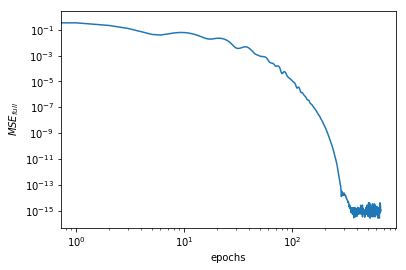

In [296]:
plt.loglog(all_losses)

plt.xlabel("epochs")
plt.ylabel("$MSE_{full}$")

In [297]:
pred = model(norm_i_feats)
mse_full([torch.from_numpy(i_ham.astype(np.float64))], pred, [i_frame], orbs)

tensor(4.7829e-16, grad_fn=<MeanBackward0>)

### Training with loss on eigenvalues

In [47]:
model = LinearModel(i_focks, i_feats)
optimizer = torch.optim.Adam(model.parameters(), lr=0.8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.01)

eigval_losses = []
for epoch in range(30000):
    optimizer.zero_grad()
    pred = model(i_feats[0])
    eigval_loss = mse_eigvals([torch.from_numpy(i_ham.astype(np.float64))], pred, [i_frame], orbs)
    eigval_loss.backward()
    optimizer.step()
    
    eigval_losses.append(eigval_loss.item())

    if epoch % 1000 == 0:
        print(epoch, eigval_loss.item())
    
    scheduler.step()

0 0.07313249260187149
1000 0.00026996646192856133
2000 5.596232099946974e-08
3000 2.7129460719479796e-14
4000 2.6957009893616504e-15
5000 9.686255856238392e-16
6000 1.296768690488997e-15
7000 3.0241524142196087e-15
8000 4.065183858482403e-15
9000 4.32505907241418e-15
10000 4.389821093978875e-15
11000 6.49571885436549e-16
12000 1.186469648284318e-15
13000 1.9500161695210376e-15
14000 1.2387532863491818e-15
15000 1.461137551486062e-15
16000 1.8999177705809715e-15
17000 2.0405432392753145e-15
18000 2.1838470261488756e-15
19000 6.112263439253442e-15
20000 1.3493779068429615e-15
21000 1.7296043264809573e-15
22000 1.7296043264809573e-15
23000 1.7296043264809573e-15
24000 1.7296043264809573e-15
25000 5.531865770003837e-16
26000 5.531865770003837e-16
27000 3.3424373261281472e-15
28000 3.3424373261281472e-15
29000 2.224811445302225e-15


Text(0, 0.5, '$MSE_{\\epsilon}$')

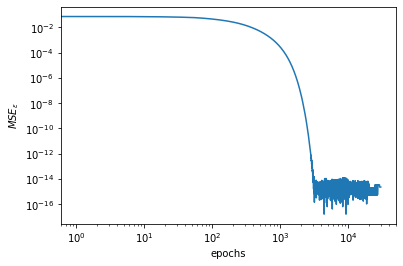

In [48]:
plt.loglog(eigval_losses)

plt.xlabel("epochs")
plt.ylabel("$MSE_{\epsilon}$")

In [49]:
pred_coupled = model(ham_feats)
rmse_full = torch.sqrt(mse_full([torch.from_numpy(i_ham.astype(np.float64))], pred, [i_frame], orbs))
print(rmse_full)

tensor(0.8015, grad_fn=<SqrtBackward0>)


# Train and test on multiple frames

### Split into train and test set

In [104]:
N=len(frames)
train_frames = frames[:int(N/5*4)]
train_hams = hams[:int(N/5*4)]
train_feats = norm_ham_feats.slice(Labels(names=["structure"], values=np.asarray(range(int(N/5*4)), dtype=np.int32).reshape(-1,1)) )
train_focks = fock_bc.slice(Labels(names=["structure"], values=np.asarray(range(int(N/5*4)), dtype=np.int32).reshape(-1,1)) )

In [105]:
test_frames = frames[int(N/5*4):N]
test_hams = hams[int(N/5*4):N]
test_feats = norm_ham_feats.slice(Labels(names=["structure"], values=np.asarray(range(int(N/5*4),N), dtype=np.int32).reshape(-1,1)) )
test_focks = fock_bc.slice(Labels(names=["structure"], values=np.asarray(range(int(N/5*4),N), dtype=np.int32).reshape(-1,1)) )

In [106]:
test_focks.block(0).values.shape

torch.Size([20, 1, 1])

In [107]:
train_focks.block(0).values.shape

torch.Size([80, 1, 1])

In [122]:
model = LinearModel(train_focks, train_feats)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=800, gamma=1e-1)

all_losses = []
for epoch in range(10000):
    optimizer.zero_grad()
    pred = model(train_feats)
    loss = mse_full(torch.from_numpy(train_hams.astype(np.float64)), pred, train_frames, orbs)
    loss.backward()
    optimizer.step()
#     scheduler.step()
    
    all_losses.append(loss.item())
    
    if epoch % 500 == 0:
        print(epoch, loss.item()) 
#     if loss.item <1e-15: 
#         break 

0 1.1269205060671084e-05
500 8.881868780008517e-06
1000 7.077041118463967e-06
1500 5.637391041091178e-06
2000 4.4376306505000684e-06


KeyboardInterrupt: 

0.056582075919331315 eV rmse on TRAIN H prediction


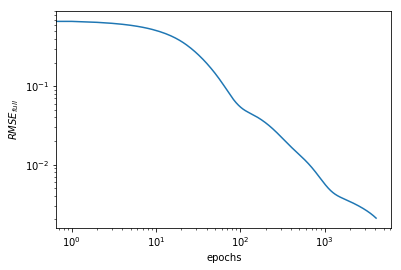

In [123]:
plt.loglog(np.sqrt(all_losses))

plt.xlabel("epochs")
plt.ylabel("$RMSE_{full}$")
print(np.sqrt(all_losses[-1])*Hartree, "eV rmse on TRAIN H prediction")

In [124]:
pred_all = model(norm_ham_feats.slice(Labels(names=["structure"], values=np.asarray(range(N), dtype=np.int32).reshape(-1,1)) ))
all_loss = mse_full(torch.from_numpy(hams[:N].astype(np.float64)), pred_all, frames[:N], orbs)
print(torch.sqrt(all_loss)*Hartree, "eV rmse on ALL H prediction")
# test_loss_eigvals = mse_eigvals(torch.from_numpy(test_hams.astype(np.float64)), pred_test, test_frames, orbs)

tensor(0.0731, grad_fn=<MulBackward0>) eV rmse on ALL H prediction


In [117]:
reindexed_pred_test.block(0).samples

Labels([( 0, 0, 0), ( 1, 0, 0), ( 2, 0, 0), ( 3, 0, 0), ( 4, 0, 0),
        ( 5, 0, 0), ( 6, 0, 0), ( 7, 0, 0), ( 8, 0, 0), ( 9, 0, 0),
        (10, 0, 0), (11, 0, 0), (12, 0, 0), (13, 0, 0), (14, 0, 0),
        (15, 0, 0), (16, 0, 0), (17, 0, 0), (18, 0, 0), (19, 0, 0)],
       dtype=[('structure', '<i4'), ('center', '<i4'), ('neighbor', '<i4')])

In [118]:
pred_test.block(0).samples

Labels([(80, 0, 0), (81, 0, 0), (82, 0, 0), (83, 0, 0), (84, 0, 0),
        (85, 0, 0), (86, 0, 0), (87, 0, 0), (88, 0, 0), (89, 0, 0),
        (90, 0, 0), (91, 0, 0), (92, 0, 0), (93, 0, 0), (94, 0, 0),
        (95, 0, 0), (96, 0, 0), (97, 0, 0), (98, 0, 0), (99, 0, 0)],
       dtype=[('structure', '<i4'), ('center', '<i4'), ('neighbor', '<i4')])

In [125]:
###TEMPORARY FIX to reindex just the test frames 
pred_test = model(test_feats)
bvalues = []
for i, b in pred_test:
    newblock = TensorBlock(
                        values=b.values,
                        samples=pred.block(i).samples[:len(b.values)],
                        components=b.components,
                        properties= b.properties)
                    
    bvalues.append(newblock) 
        
reindexed_pred_test  = TensorMap(test_focks.keys, bvalues)

In [126]:
# reindexed_pred_test.block(0).samples

In [127]:
test_loss = mse_full(torch.from_numpy(test_hams.astype(np.float64)), reindexed_pred_test, test_frames, orbs)
test_loss_eigvals = mse_eigvals(torch.from_numpy(test_hams.astype(np.float64)), reindexed_pred_test, test_frames, orbs)
print(torch.sqrt(test_loss)*Hartree,  "eV rmse on TEST H prediction")
print(torch.sqrt(test_loss_eigvals),  "eV rmse on TEST eigen prediction")

tensor(0.1180, grad_fn=<MulBackward0>) eV rmse on TEST H prediction
tensor(0.0014, grad_fn=<SqrtBackward0>) eV rmse on TEST eigen prediction
